In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib notebook

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [4]:
import lib_subspaces as lsub

In [5]:
cd ~/HPT_500k/HPT_LS20_DOM80_TI5/Subspaces/

/mnt/drive2/re_500k/HPT_LS20_DOM80_TI5/Subspaces


In [6]:
blocks=range(1,5)

start_TS=5204601
stop_TS= 5243601
inc_TS=500
steps=range(start_TS,stop_TS,inc_TS)
tau_w=lsub.subspace('WALL_SH_HEAT',20,start_TS,blocks,source_folder='./')
tau_w.load_grid()
tau_w.load_data(steps)

The dataset requires 2383.646484 Mb of RAM


In [7]:
sim_ts=2.1*10**(-5)
dt=inc_TS*sim_ts
f_sub=1./dt
nsteps=len(steps)
print 'number of steps in Subspaces: %i'%nsteps

number of steps in Subspaces: 78


In [8]:
id_min=np.argmin(tau_w.grid[0][0,0,:,0])
arc_length=[]
nxp,nyp,nzp = tau_w.header[0][0]
temp=np.empty(nyp)
temp[id_min]=0.
for i in range(id_min+1,nyp,1):
    temp[i]=temp[i-1]+np.sqrt((tau_w.grid[0][0,0,i,0]-tau_w.grid[0][0,0,i-1,0])**2
                             +(tau_w.grid[0][1,0,i,0]-tau_w.grid[0][1,0,i-1,0])**2)
arc_length.append(temp)
for ib in range(2,4):
    nxp,nyp,nzp = tau_w.header[0][ib]
    temp=np.empty(nyp)
    temp[0]=arc_length[-1][-1]
    for i in range(1,nyp):
        temp[i]=temp[i-1]+np.sqrt((tau_w.grid[ib][0,0,i,0]-tau_w.grid[ib][0,0,i-1,0])**2
                                 +(tau_w.grid[ib][1,0,i,0]-tau_w.grid[ib][1,0,i-1,0])**2)
    arc_length.append(temp)
plt.figure()
plt.plot(tau_w.grid[3][0,0,:,0],arc_length[2])

<IPython.core.display.Javascript object>

# Compute histogram

In [9]:
levs=np.logspace(0,2.4,num=9)
norml = matplotlib.colors.BoundaryNorm(levs, 256)

In [10]:
min_val=-0.1
max_val=0.15
tau_w_hist=np.empty([50,672+383])
j=50
bl=0
for j in range(672):
    a=np.histogram(-tau_w.data[2][0,:,0,j,:],range=(-0.01,max_val),bins=50,density=True)
    tau_w_hist[:,j]=a[0]
for j in range(1,384):  
    a=np.histogram(-tau_w.data[3][0,:,0,j,:],range=(-0.01,max_val),bins=50,density=True)
    tau_w_hist[:,j+671]=a[0]    
bins=a[1]



In [11]:
intv=bins[:-1]+(max_val+min_val)/100.
l=np.concatenate([arc_length[1][:-1],arc_length[2]])
X,Y=np.meshgrid(l,intv)


In [12]:
plt.figure(figsize=(6,4))
plt.contourf(X,Y,tau_w_hist,levels=levs,norm=norml,extend='min')
plt.colorbar()
plt.xlabel('$s$')
plt.ylabel('hist$\left(\\tau_w\\right)$')
plt.tight_layout()
plt.savefig('../hist_tau_TI05_LS20.pdf')
plt.grid()

<IPython.core.display.Javascript object>

In [13]:
fact_qn=((1.+0.3686)/(1.35+0.3686))*(1.35**(1.5))/(1.81-1.35)
levs_heat=np.logspace(-5,-2,num=11)
norml_heat = matplotlib.colors.BoundaryNorm(levs_heat, 256)
max_val_heat=2000.
min_val_heat=-100.
heat_flux_hist=np.empty([200,672+383])
j=50
bl=0
for j in range(672):
    a=np.histogram(tau_w.data[2][1,:,0,j,:]*fact_qn,range=(min_val_heat,max_val_heat),bins=200,density=True)
    heat_flux_hist[:,j]=a[0]
for j in range(1,384):  
    a=np.histogram(tau_w.data[3][1,:,0,j,:]*fact_qn,range=(min_val_heat,max_val_heat),bins=200,density=True)
    heat_flux_hist[:,j+671]=a[0]    
bins_heat=a[1]

In [14]:

intv_heat=bins_heat[:-1]+(max_val_heat+min_val_heat)/100.
l=np.concatenate([arc_length[1][:-1],arc_length[2]])
X,Y=np.meshgrid(l,intv)
X_heat,Y_heat=np.meshgrid(l,intv_heat)

In [15]:
plt.figure(figsize=(6,4))
plt.contourf(X,Y,tau_w_hist,levels=levs,norm=norml,extend='min')
plt.colorbar()
plt.xlabel('$s$')
plt.ylabel('hist$\left(\\tau_w\\right)$')
plt.tight_layout()
plt.savefig('../hist_tau_TI05_LS05.pdf')
plt.grid()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


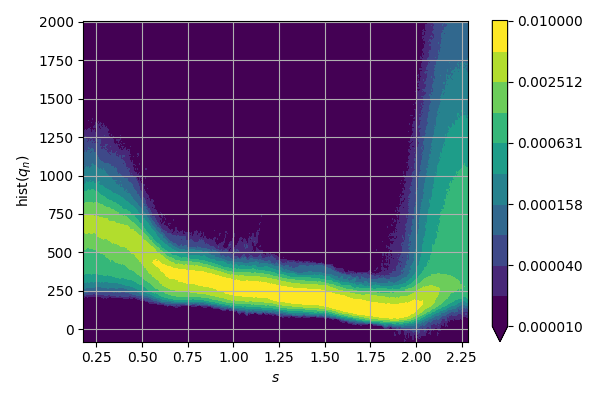

In [22]:
plt.figure(figsize=(6,4))
plt.contourf(X_heat,Y_heat,heat_flux_hist,levels=levs_heat,norm=norml_heat,extend='min')
plt.colorbar()
plt.xlabel('$s$')
plt.ylabel('hist$\left(q_{n}\\right)$')
plt.tight_layout()
plt.grid()
plt.savefig('../hist_heat_TI06_LS20.pdf')

In [17]:
plt.figure()
for j in range(600,900,50):
    plt.plot(Y_heat[:,j],heat_flux_hist[:,j],label='x=%6.3f'%X_heat[0,j])
plt.legend()

<IPython.core.display.Javascript object>

# Spectra

## 1D PSD

In [18]:
import spectral_functions as sf

In [19]:
max_val=0.15
nfft=200
nz=10
tau_w_psd=np.zeros([nfft/2+1,672+383])
for j in range(672):
    a=np.zeros(nfft/2+1)
    for nz in range(0,384,2):
        a+=sf.spectral_func(-tau_w.data[2][0,:,0,j,nz],-tau_w.data[2][0,:,0,j,nz],Fs=f_sub,NFFT=nfft,scale='spectrum')
    tau_w_psd[:,j]=a
for j in range(1,384):  
    a=np.zeros(nfft/2+1)
    for nz in range(0,384,2):
        a+=sf.spectral_func(-tau_w.data[3][0,:,0,j,nz],-tau_w.data[3][0,:,0,j,nz],Fs=f_sub,NFFT=nfft,scale='spectrum')
    tau_w_psd[:,j+671]=a    
frq=sf.get_freqs(-tau_w.data[2][0,:,0,j,0],NFFT=nfft,Fs=f_sub)

IndexError: too many indices for array

In [ ]:
Xs,Ys=np.meshgrid(l,frq)
print frq

In [ ]:
levs=np.logspace(-6,-1,num=11)
norml = matplotlib.colors.BoundaryNorm(levs, 256)

In [ ]:
plt.figure()
plt.contourf(Xs,Ys,tau_w_psd,levels=levs,norm=norml)
plt.colorbar()

In [ ]:
print np.max(tau_w.data[2][1,:,0,:,:]*fact_qn)
print np.min(tau_w.data[2][1,:,0,:,:]*fact_qn)

In [ ]:
plt.figure()
for k in range(0,300,20):
    plt.plot(tau_w.grid[2][0,0,:,0],tau_w.data[2][1,1,0,:,k]*fact_qn)